In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
from sklearn.svm import *
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score
import seaborn as sns
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import *
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import poisson, expon, uniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.kernel_approximation import Nystroem
import random
import math

### Słowem wstępu:
Pracę domową rozpocząłem w piątek, 24 kwietnia, zatem dane samodzielnie przetransferowałem z pakietu R-owego oraz postanowiłem się zająć zadaniem regresji zmiennej 'm2.price'. Ponadto, punkt 1. treści zadania domowego jest częścią punktu 3., zatem od razu zająłem się poszukiwaniem optymalnych hiperparametrów.
#### Ponieważ oryginalnie w ramce danych 'apartments' znajduje się 1000 obserwacji, a w 'apartments_test' 9000 obserwacji, dla zwiększenia skuteczności algorytmu dokonamy zamiany zbiorów

In [2]:
apart_test = pd.read_csv('apartments.csv').drop('Unnamed: 0', axis = 1)
apart = pd.read_csv('apartments_test.csv').drop('Unnamed: 0', axis = 1)
apart.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,4644,1976,131,3,5,Srodmiescie
1,3082,1978,112,9,4,Mokotow
2,2498,1958,100,7,4,Bielany
3,2735,1951,112,3,5,Wola
4,2781,1978,102,4,4,Bemowo


In [3]:
apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           9000 non-null   int64 
 1   construction.year  9000 non-null   int64 
 2   surface            9000 non-null   int64 
 3   floor              9000 non-null   int64 
 4   no.rooms           9000 non-null   int64 
 5   district           9000 non-null   object
dtypes: int64(5), object(1)
memory usage: 422.0+ KB


In [4]:
apart_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           1000 non-null   int64 
 1   construction.year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no.rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


In [5]:
print("Zbiór treningowy:\n" + str(apart.district.value_counts(True)))
print("Zbiór testowy:\n" + str(apart_test.district.value_counts(True)))

Zbiór treningowy:
Praga          0.107889
Srodmiescie    0.102667
Ursus          0.102222
Ochota         0.101000
Bemowo         0.099556
Bielany        0.099333
Wola           0.099111
Mokotow        0.096444
Ursynow        0.096000
Zoliborz       0.095778
Name: district, dtype: float64
Zbiór testowy:
Mokotow        0.107
Wola           0.106
Ursus          0.105
Ursynow        0.103
Srodmiescie    0.100
Bemowo         0.098
Zoliborz       0.097
Ochota         0.096
Bielany        0.096
Praga          0.092
Name: district, dtype: float64


#### Zbiór danych składa się z mieszkań w dziesięciu dzielnicach Warszawy, podobna liczba obserwacji pochodzi z każdej z dzielnic. Co istotne, wszystkie dzielnice w zbiorze danych testowych znajdują się w danych do treningu

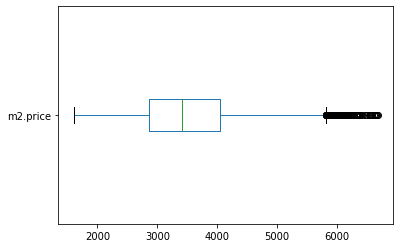

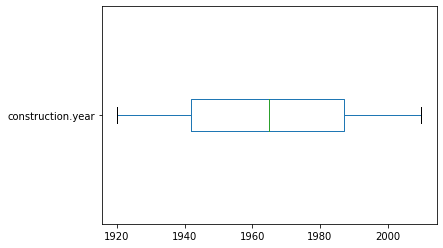

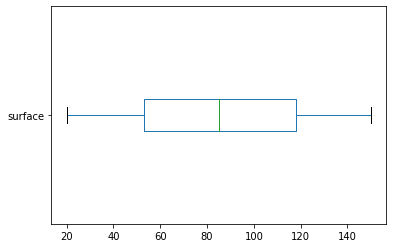

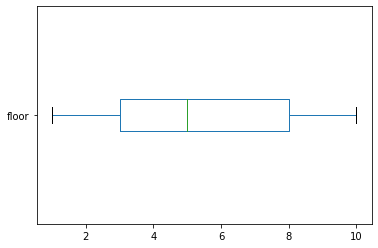

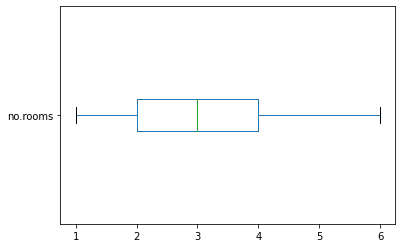

In [6]:
for col in apart.select_dtypes('int64').columns:
    apart[[col]].plot.box(vert = False)

#### Najczęściej mieszkania są w cenie 3000-4000 za metr kwadratowy. Cena za metr jest jedyną zmienną, w której występują wartości odstające. Mieszkania zazwyczaj są powierzchni 50-115 metrów kwadratowych, 2-4 pokojowe, na piętrach od parteru do 10.

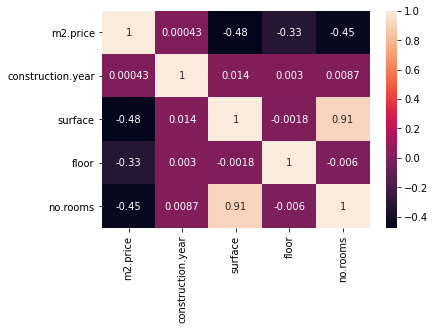

In [7]:
sns.heatmap(apart.corr(), annot=True)

#### Z macierzy korelacji nie ma wiele zaskakujących wniosków: najwyższa wartość współczynnika korelacji, dość oczekiwanie, wystąpiła między powierzchnią mieszkania a liczbą pomieszczeń. Co ciekawe, na im wyższym piętrze znajduje się mieszkanie, tym zwykle jest tańsze.

In [8]:
apart[['district', 'm2.price']].groupby('district').median()

,m2.price
district,
Bemowo,3030.0
Bielany,3057.5
Mokotow,3924.5
Ochota,3941.0
Praga,3054.0
Srodmiescie,5120.0
Ursus,3002.5
Ursynow,3003.0
Wola,3040.5


#### Im bliżej centrum, tym wyższa jest cena za metr kwadratowy mieszkania - najwyższa mediana cen w Śródmieściu, najniższa na Ursusie.
#### Oddzielmy dane od Targetu. Wobec Targetu będzie zastosujemy jedynie zabieg normalizacji danych.

In [9]:
train_target = apart['m2.price']
test_target = apart_test['m2.price']
apart = apart.drop('m2.price', axis = 1)
apart_test = apart_test.drop('m2.price', axis = 1)

## Zbadanie wpływu skalowania danych na efektywność `SVR()`

Celem zbadania wpływu skalowania danych dokonamy dwóch testów: jak wpłynie standaryzacja oraz normalizacja zmiennych przed trenowaniem modelu. Następnie zaprezentujemy wyniki z uzyciem różnych miar modeli regresji.<br>


In [85]:
def test_pipeline(pipeline):
    param_distributions = {'svr__C': uniform(loc = 0.01, scale = 2),
                           'svr__gamma': expon(0.05),
                           'svr__degree': randint(low = 1, high = 3),
                           'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                           'svr__epsilon': uniform(0.005, scale = 0.12)}

    rscv = RandomizedSearchCV(pipeline, param_distributions=param_distributions,
                          scoring = 'neg_root_mean_squared_error',
                          cv = 4, random_state = 324, n_iter = 10,
                          verbose = 10**8)

    return rscv.fit(apart, train_target)

### Uwagi co do strojenia hiperparametrów:
* SVR nie posiada parametru cost. Zamiennie zastosowałem parametr C - dodatni parametr regularyzacji
* Parametr gamma - sposób ustawienia współczynnika dla jądra w przypadku gdy jest ono jednym z 'rbf' - Gaussian radial basis function, 'poly' - Polynomial, 'sigmoid'. Wartość współczynnika w przypadku gdy gamma = 'scale' jest zależna od rozmiaru danych wejściowych i wynosi 1/(n_features() * X.var()). Gdy 'gamma' = 'auto', jego wartość to po prostu 1/n_features. Dla celów badawczych sprawdzimy jak spiszą się wartości tego parametru z rozkładu wykładniczego o parametrze 0.05).
* Parametr degree - określa stopień wielomianu dla jądra 'poly'. W przeciwnym razie - jest ignorowany. Co ciekawe, gdy degree było liczbą z zakresu 3-6, obliczenia trwały nieporównywalnie dłużej (żadne nie doszło do skutku w rozsądnym czasie)
* kernel - rodzaj jądra
* epsilon - o ile dobrze rozumiem, jest to określenie pewnego marginesu, na którym nie jest stosowana żadna kara za niepoprawną predykcję; możliwa pomyłka bez kary<br>
W celu poprawnego stosowania kodowania zmiennej kateogrycznej w procesie poszukiwania optymalnych hiperparametrów, zastosujemy obiekt ColumnTransofrmer

In [86]:
column_transformer = ColumnTransformer([('encoder', TargetEncoder(cols = ['district']), ['district'])],
                                       remainder= 'passthrough')
basic_ppl = Pipeline(steps = [('transformer', column_transformer), ('svr', SVR())])
standarizing_ppl = Pipeline(steps = [('transformer', column_transformer), ('standardize', StandardScaler()), ('svr', SVR())])
normalizing_ppl = Pipeline(steps = [('transformer', column_transformer), ('normalize', Normalizer()), ('svr', SVR())])
pipelines = [basic_ppl, standarizing_ppl, normalizing_ppl]

estimators = []
for ppl in pipelines:
    estimators.append(test_pipeline(ppl))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.046977657429356556, svr__gamma=0.6578228796276598, svr__kernel=sigmoid 
[CV]  svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.046977657429356556, svr__gamma=0.6578228796276598, svr__kernel=sigmoid, score=-893.875, total=   1.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.046977657429356556, svr__gamma=0.6578228796276598, svr__kernel=sigmoid 
[CV]  svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.046977657429356556, svr__gamma=0.6578228796276598, svr__kernel=sigmoid, score=-907.108, total=   1.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[CV] svr__C=0.13063342713081472, svr__degree=1, svr__epsilon=0.046977657429356556, svr__gamma=0.

[CV]  svr__C=1.8629012406080114, svr__degree=1, svr__epsilon=0.012484132524292368, svr__gamma=0.14092244342005547, svr__kernel=poly, score=-333.866, total=  26.7s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  4.9min remaining:    0.0s
[CV] svr__C=1.8629012406080114, svr__degree=1, svr__epsilon=0.012484132524292368, svr__gamma=0.14092244342005547, svr__kernel=poly 
[CV]  svr__C=1.8629012406080114, svr__degree=1, svr__epsilon=0.012484132524292368, svr__gamma=0.14092244342005547, svr__kernel=poly, score=-338.838, total=  10.8s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  5.1min remaining:    0.0s
[CV] svr__C=0.8586175177346542, svr__degree=1, svr__epsilon=0.009482093023722564, svr__gamma=0.6599015899590189, svr__kernel=poly 
[CV]  svr__C=0.8586175177346542, svr__degree=1, svr__epsilon=0.009482093023722564, svr__gamma=0.6599015899590189, svr__kernel=poly, score=-336.320, total=  22.2s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.5min remaining:    0.0s
[CV] svr_

[CV]  svr__C=1.06634387784026, svr__degree=2, svr__epsilon=0.041593705931671436, svr__gamma=0.1431659520827605, svr__kernel=poly, score=-831.681, total=   1.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.0s remaining:    0.0s
[CV] svr__C=1.06634387784026, svr__degree=2, svr__epsilon=0.041593705931671436, svr__gamma=0.1431659520827605, svr__kernel=poly 
[CV]  svr__C=1.06634387784026, svr__degree=2, svr__epsilon=0.041593705931671436, svr__gamma=0.1431659520827605, svr__kernel=poly, score=-844.606, total=   1.8s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.8s remaining:    0.0s
[CV] svr__C=1.06634387784026, svr__degree=2, svr__epsilon=0.041593705931671436, svr__gamma=0.1431659520827605, svr__kernel=poly 
[CV]  svr__C=1.06634387784026, svr__degree=2, svr__epsilon=0.041593705931671436, svr__gamma=0.1431659520827605, svr__kernel=poly, score=-843.722, total=   1.5s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.4s remaining:    0.0s
[CV] svr__C=1.06634387

[CV]  svr__C=0.8586175177346542, svr__degree=1, svr__epsilon=0.009482093023722564, svr__gamma=0.6599015899590189, svr__kernel=poly, score=-333.518, total=   1.7s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.2min remaining:    0.0s
[CV] svr__C=0.8586175177346542, svr__degree=1, svr__epsilon=0.009482093023722564, svr__gamma=0.6599015899590189, svr__kernel=poly 
[CV]  svr__C=0.8586175177346542, svr__degree=1, svr__epsilon=0.009482093023722564, svr__gamma=0.6599015899590189, svr__kernel=poly, score=-338.861, total=   1.7s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.3min remaining:    0.0s
[CV] svr__C=1.6569432431418691, svr__degree=2, svr__epsilon=0.08016717871294388, svr__gamma=0.5106111375796986, svr__kernel=sigmoid 
[CV]  svr__C=1.6569432431418691, svr__degree=2, svr__epsilon=0.08016717871294388, svr__gamma=0.5106111375796986, svr__kernel=sigmoid, score=-524.416, total=   3.9s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  1.3min remaining:    0.0s
[CV] svr

[CV]  svr__C=0.5092115697307078, svr__degree=1, svr__epsilon=0.07938067348268311, svr__gamma=0.8831643985403481, svr__kernel=sigmoid, score=-890.458, total=   4.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   29.7s remaining:    0.0s
[CV] svr__C=0.5092115697307078, svr__degree=1, svr__epsilon=0.07938067348268311, svr__gamma=0.8831643985403481, svr__kernel=sigmoid 
[CV]  svr__C=0.5092115697307078, svr__degree=1, svr__epsilon=0.07938067348268311, svr__gamma=0.8831643985403481, svr__kernel=sigmoid, score=-903.677, total=   3.5s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.2s remaining:    0.0s
[CV] svr__C=0.5092115697307078, svr__degree=1, svr__epsilon=0.07938067348268311, svr__gamma=0.8831643985403481, svr__kernel=sigmoid 
[CV]  svr__C=0.5092115697307078, svr__degree=1, svr__epsilon=0.07938067348268311, svr__gamma=0.8831643985403481, svr__kernel=sigmoid, score=-911.771, total=   4.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   37.2s remaining:    0.0s
[C

[CV]  svr__C=1.6569432431418691, svr__degree=2, svr__epsilon=0.08016717871294388, svr__gamma=0.5106111375796986, svr__kernel=sigmoid, score=-905.258, total=   3.5s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:  1.6min remaining:    0.0s
[CV] svr__C=1.6569432431418691, svr__degree=2, svr__epsilon=0.08016717871294388, svr__gamma=0.5106111375796986, svr__kernel=sigmoid 
[CV]  svr__C=1.6569432431418691, svr__degree=2, svr__epsilon=0.08016717871294388, svr__gamma=0.5106111375796986, svr__kernel=sigmoid, score=-898.465, total=   3.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.7min remaining:    0.0s
[CV] svr__C=0.617398430891392, svr__degree=1, svr__epsilon=0.11139326774310797, svr__gamma=0.19329441573696887, svr__kernel=rbf 
[CV]  svr__C=0.617398430891392, svr__degree=1, svr__epsilon=0.11139326774310797, svr__gamma=0.19329441573696887, svr__kernel=rbf, score=-890.284, total=   3.3s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.7min remaining:    0.0s
[CV] svr__

In [93]:
def czas_dzialania(estimators):
    label = ['Model bez skalowania', 'Model po standaryzacji', 'Model po normalizacji']
    j = 0
    print('CZAS DZIAŁANIA:')
    for est in estimators:
        print('\n', label[j])
        j = j+1
        print("Czas działania wszystkich podzbiorów parametrów:\n" + str(est.cv_results_['mean_fit_time']) + '\n')
        print('Czasy dla kernel = "poly": ' + 
          str(est.cv_results_['mean_fit_time'][np.array([i['svr__kernel'] for i in est.cv_results_['params']]) == 'poly']))

In [94]:
czas_dzialania(estimators)

CZAS DZIAŁANIA:

 Model bez skalowania
Czas działania wszystkich podzbiorów parametrów:
[ 1.23920888 38.32451957  1.65163112  2.35196602  1.64666271 30.17994088
 33.0666182   1.38872522  2.21469086  1.96010733]

Czasy dla kernel = "poly": [38.32451957 30.17994088 33.0666182 ]

 Model po standaryzacji
Czas działania wszystkich podzbiorów parametrów:
[3.24230498 1.53603506 3.1827423  2.20865041 2.97441822 1.66735041
 1.64999592 3.41959763 2.35297561 2.53809881]

Czasy dla kernel = "poly": [1.53603506 1.66735041 1.64999592]

 Model po normalizacji
Czas działania wszystkich podzbiorów parametrów:
[3.5572921  2.08598703 3.36857992 2.97306585 3.10540563 2.15610582
 2.10575467 2.7800796  2.59943897 2.71196514]

Czasy dla kernel = "poly": [2.08598703 2.15610582 2.10575467]


Od razu rzuca się w oczy, że czas działania SVR dla danych nieskalowanych i jądra wielomianowego jest znacznie dłuższy niż w przeciwnych przypadkach.

In [95]:
def najlepsze_parametry(estimators):
    label = ['Model bez skalowania', 'Model po standaryzacji', 'Model po normalizacji']
    j = 0
    print('NAJLEPSZE PARAMETRY:')
    for est in estimators:
        print(label[j])
        j = j+1
        print(est.best_params_, '\n')

In [96]:
najlepsze_parametry(estimators)

NAJLEPSZE PARAMETRY:
Model bez skalowania
{'svr__C': 0.8586175177346542, 'svr__degree': 1, 'svr__epsilon': 0.009482093023722564, 'svr__gamma': 0.6599015899590189, 'svr__kernel': 'poly'} 

Model po standaryzacji
{'svr__C': 1.8629012406080114, 'svr__degree': 1, 'svr__epsilon': 0.012484132524292368, 'svr__gamma': 0.14092244342005547, 'svr__kernel': 'poly'} 

Model po normalizacji
{'svr__C': 0.9389662586977892, 'svr__degree': 2, 'svr__epsilon': 0.09173600246078598, 'svr__gamma': 0.527248481313933, 'svr__kernel': 'rbf'} 



Co ciekawe, najlepszym jądrem dla danych po normalizacji, okazało się 'rbf' - domyślna wartość oznaczająca radialną funkcję bazową.

In [97]:
def plot_estimators(estimators, test_data, test_target):
    r2 = []
    evs = []
    rmse = []
    for est in estimators:
        pred = est.best_estimator_.predict(test_data)
        r2.append(r2_score(test_target, pred))
        evs.append(explained_variance_score(test_target, pred))
        rmse.append(math.sqrt(mean_squared_error(test_target, pred)))

    _, ax = plt.subplots()
    plt.bar(x = ['Bez skalowania', 'Po standaryzacji', 'Po normalizacji'], height = r2)
    plt.title('Miara R2')
    for i, v in enumerate(r2):
        ax.text(i-0.125, v*1.25 if i ==2 else v*0.93, str(round(v, 3)), color='white' if i != 2 else 'blue', fontweight='bold')
    plt.show()

    _, ax = plt.subplots()
    plt.bar(x = ['Bez skalowania', 'Po standaryzacji', 'Po normalizacji'], height = evs)
    plt.title('Miara explained_variance_score')
    for i, v in enumerate(evs):
        ax.text(i-0.125, v*1.4 if i ==2 else v*0.95, str(round(v, 3)), color='white' if i != 2 else 'blue', fontweight='bold')
    plt.show()

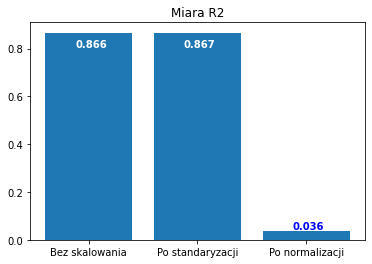

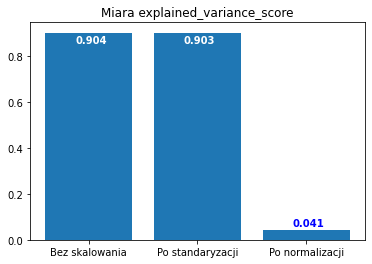

In [98]:
plot_estimators(estimators, apart_test, test_target)

### Standaryzacja praktycznie nie przyniosła żadnych zmian w otzrymanych wynikach. Zaskakująco bliskie wyniki skłaniają wręcz do zastanowienia się, czy `SVR()` domyślnie nie standaryzuje danych, jednak nie znalazłem nigdzie potwierdzającej informacji.

## Drugi zbiór danych - zawodnicy w grze FIFA 20

In [22]:
fifa_read = pd.read_csv('players_20.csv')

In [23]:
fifa_numeric = fifa_read.select_dtypes(['float64', 'int64'])
fifa_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sofifa_id                   18278 non-null  int64  
 1   age                         18278 non-null  int64  
 2   height_cm                   18278 non-null  int64  
 3   weight_kg                   18278 non-null  int64  
 4   overall                     18278 non-null  int64  
 5   potential                   18278 non-null  int64  
 6   value_eur                   18278 non-null  int64  
 7   wage_eur                    18278 non-null  int64  
 8   international_reputation    18278 non-null  int64  
 9   weak_foot                   18278 non-null  int64  
 10  skill_moves                 18278 non-null  int64  
 11  release_clause_eur          16980 non-null  float64
 12  team_jersey_number          18038 non-null  float64
 13  contract_valid_until        180

#### Starałem się dokonać selekcji moim zdaniem najważniejszych zmiennych

In [24]:
fifa_selected = fifa_numeric[['age', 'height_cm', 'weight_kg', 'overall', 'potential', 'value_eur',
                              'international_reputation','weak_foot', 'skill_moves', 'pace', 'shooting', 'passing',
                              'dribbling', 'defending', 'physic']]

In [25]:
fifa_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       18278 non-null  int64  
 1   height_cm                 18278 non-null  int64  
 2   weight_kg                 18278 non-null  int64  
 3   overall                   18278 non-null  int64  
 4   potential                 18278 non-null  int64  
 5   value_eur                 18278 non-null  int64  
 6   international_reputation  18278 non-null  int64  
 7   weak_foot                 18278 non-null  int64  
 8   skill_moves               18278 non-null  int64  
 9   pace                      16242 non-null  float64
 10  shooting                  16242 non-null  float64
 11  passing                   16242 non-null  float64
 12  dribbling                 16242 non-null  float64
 13  defending                 16242 non-null  float64
 14  physic

#### Wykorzystajmy jedynie obserwacje bez braków danych - pozostali to najprawdopodbniej bramkarze, dla których niektóre atrybuty nie zostały określone

In [26]:
fifa = fifa_selected.dropna().reset_index()

In [27]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     16242 non-null  int64  
 1   age                       16242 non-null  int64  
 2   height_cm                 16242 non-null  int64  
 3   weight_kg                 16242 non-null  int64  
 4   overall                   16242 non-null  int64  
 5   potential                 16242 non-null  int64  
 6   value_eur                 16242 non-null  int64  
 7   international_reputation  16242 non-null  int64  
 8   weak_foot                 16242 non-null  int64  
 9   skill_moves               16242 non-null  int64  
 10  pace                      16242 non-null  float64
 11  shooting                  16242 non-null  float64
 12  passing                   16242 non-null  float64
 13  dribbling                 16242 non-null  float64
 14  defend

#### Udało nam sie przygotować całkiem pokaźny zbiór danych o wymiarach 16242 x 15.

In [28]:
fifa.corr()

,index,age,height_cm,weight_kg,overall,potential,value_eur,international_reputation,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic
index,1.000000,-0.437896,-0.063343,-0.175966,-0.973598,-0.638629,-0.544546,-0.393322,-0.218572,-0.495640,-0.154866,-0.486231,-0.667273,-0.585396,-0.327378,-0.504749
age,-0.437896,1.000000,0.065503,0.222893,0.465977,-0.275971,0.087288,0.264483,0.109420,0.130075,-0.201211,0.238990,0.330507,0.161913,0.259990,0.435292
height_cm,-0.063343,0.065503,1.000000,0.752597,0.065984,0.021387,0.025051,0.043452,-0.097984,-0.280113,-0.432158,-0.203716,-0.290623,-0.413370,0.216422,0.490354
weight_kg,-0.175966,0.222893,0.752597,1.000000,0.182136,0.009379,0.066650,0.097335,-0.055569,-0.201295,-0.387138,-0.095442,-0.182688,-0.300792,0.218564,0.581971
overall,-0.973598,0.465977,0.065984,0.182136,1.000000,0.636026,0.645949,0.478061,0.227624,0.493554,0.158866,0.497881,0.683954,0.601190,0.334792,0.517214
potential,-0.638629,-0.275971,0.021387,0.009379,0.636026,1.000000,0.581976,0.337049,0.150349,0.380834,0.229060,0.304000,0.424816,0.451097,0.151608,0.148449
value_eur,-0.544546,0.087288,0.025051,0.066650,0.645949,0.581976,1.000000,0.621826,0.170129,0.370318,0.171373,0.343938,0.448258,0.427721,0.157928,0.236395
international_reputation,-0.393322,0.264483,0.043452,0.097335,0.478061,0.337049,0.621826,1.000000,0.134880,0.260275,0.004324,0.274709,0.355577,0.296900,0.138748,0.176956
weak_foot,-0.218572,0.109420,-0.097984,-0.055569,0.227624,0.150349,0.170129,0.134880,1.000000,0.266627,0.148527,0.319034,0.281381,0.309823,-0.105863,0.000952
skill_moves,-0.495640,0.130075,-0.280113,-0.201295,0.493554,0.380834,0.370318,0.260275,0.266627,1.000000,0.420886,0.625012,0.611950,0.714841,-0.209321,-0.066725


### Naszą zmienną objaśnianą będzie wartość zawodników - kolumna 'value_eur'. Najbardziej skorelowana z nią jest kolumna overall - łączny wynik umiejętności gracz. Wsp. korelacji: 0.64

#### Podział danych na treningowe i testowe:

In [29]:
data_train, data_test, target_train, target_test = train_test_split(fifa.drop(['index','value_eur'], axis = 1), fifa.value_eur)

In [30]:
def fifa_pipeline_test(ppl):
    param_distributions = {'svr__C': uniform(loc = 0.01, scale = 2),
                           'svr__gamma': expon(0.05),
                           'svr__degree': [1], # Tylko 1, gdy 'poly' natrafił na 2, czas działania na tak dużym zbiorze rósł dramatycznie
                           'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                           'svr__epsilon': uniform(0.02, scale = 0.3)}

    fifa_rscv = RandomizedSearchCV(ppl, param_distributions=param_distributions,
                              scoring = 'neg_root_mean_squared_error',
                              cv = 4, random_state = 794, n_iter = 10,
                              verbose = 10**8)

    return fifa_rscv.fit(data_train, target_train)

In [31]:
fifa_basic_ppl = Pipeline(steps = [('svr', SVR())])
fifa_standarizing_ppl = Pipeline(steps = [('standardize', StandardScaler()), ('svr', SVR())])
fifa_normalizing_ppl = Pipeline(steps = [('normalize', Normalizer()), ('svr', SVR())])
fifa_pipelines = [fifa_basic_ppl, fifa_standarizing_ppl, fifa_normalizing_ppl]

fifa_estimators = []
for ppl in fifa_pipelines:
    fifa_estimators.append(fifa_pipeline_test(ppl))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] svr__C=1.6860268988646951, svr__degree=1, svr__epsilon=0.31706150737197836, svr__gamma=0.9131598644317059, svr__kernel=linear 
[CV]  svr__C=1.6860268988646951, svr__degree=1, svr__epsilon=0.31706150737197836, svr__gamma=0.9131598644317059, svr__kernel=linear, score=-5115092.132, total=   3.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[CV] svr__C=1.6860268988646951, svr__degree=1, svr__epsilon=0.31706150737197836, svr__gamma=0.9131598644317059, svr__kernel=linear 
[CV]  svr__C=1.6860268988646951, svr__degree=1, svr__epsilon=0.31706150737197836, svr__gamma=0.9131598644317059, svr__kernel=linear, score=-5916675.514, total=   3.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[CV] svr__C=1.6860268988646951, svr__degree=1, svr__epsilon=0.31706150737197836, svr__gamma=0.913159

[CV]  svr__C=1.222351196275172, svr__degree=1, svr__epsilon=0.25432816972647815, svr__gamma=0.8938856221404047, svr__kernel=rbf, score=-6378697.566, total=   5.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.4min remaining:    0.0s
[CV] svr__C=1.222351196275172, svr__degree=1, svr__epsilon=0.25432816972647815, svr__gamma=0.8938856221404047, svr__kernel=rbf 
[CV]  svr__C=1.222351196275172, svr__degree=1, svr__epsilon=0.25432816972647815, svr__gamma=0.8938856221404047, svr__kernel=rbf, score=-6328663.926, total=   5.1s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  1.5min remaining:    0.0s
[CV] svr__C=1.222351196275172, svr__degree=1, svr__epsilon=0.25432816972647815, svr__gamma=0.8938856221404047, svr__kernel=rbf 
[CV]  svr__C=1.222351196275172, svr__degree=1, svr__epsilon=0.25432816972647815, svr__gamma=0.8938856221404047, svr__kernel=rbf, score=-6008596.034, total=   5.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.6min remaining:    0.0s
[CV] svr__C=0.2

[CV]  svr__C=1.6860268988646951, svr__degree=1, svr__epsilon=0.31706150737197836, svr__gamma=0.9131598644317059, svr__kernel=linear, score=-5978898.718, total=   3.5s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.0s remaining:    0.0s
[CV] svr__C=1.3392816696934942, svr__degree=1, svr__epsilon=0.19048477846607265, svr__gamma=0.5035089945419189, svr__kernel=sigmoid 
[CV]  svr__C=1.3392816696934942, svr__degree=1, svr__epsilon=0.19048477846607265, svr__gamma=0.5035089945419189, svr__kernel=sigmoid, score=-5616835.211, total=   7.1s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.2s remaining:    0.0s
[CV] svr__C=1.3392816696934942, svr__degree=1, svr__epsilon=0.19048477846607265, svr__gamma=0.5035089945419189, svr__kernel=sigmoid 
[CV]  svr__C=1.3392816696934942, svr__degree=1, svr__epsilon=0.19048477846607265, svr__gamma=0.5035089945419189, svr__kernel=sigmoid, score=-6376149.857, total=   7.1s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   28.3s remaining:

[CV]  svr__C=0.2573371031061482, svr__degree=1, svr__epsilon=0.05038001388556295, svr__gamma=1.032091863071393, svr__kernel=poly, score=-6373986.136, total=   4.6s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  2.3min remaining:    0.0s
[CV] svr__C=0.2573371031061482, svr__degree=1, svr__epsilon=0.05038001388556295, svr__gamma=1.032091863071393, svr__kernel=poly 
[CV]  svr__C=0.2573371031061482, svr__degree=1, svr__epsilon=0.05038001388556295, svr__gamma=1.032091863071393, svr__kernel=poly, score=-6323483.607, total=   5.3s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.4min remaining:    0.0s
[CV] svr__C=0.2573371031061482, svr__degree=1, svr__epsilon=0.05038001388556295, svr__gamma=1.032091863071393, svr__kernel=poly 
[CV]  svr__C=0.2573371031061482, svr__degree=1, svr__epsilon=0.05038001388556295, svr__gamma=1.032091863071393, svr__kernel=poly, score=-6004123.766, total=   5.2s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  2.5min remaining:    0.0s
[CV] svr__

[CV]  svr__C=1.3392816696934942, svr__degree=1, svr__epsilon=0.19048477846607265, svr__gamma=0.5035089945419189, svr__kernel=sigmoid, score=-6008591.754, total=   8.7s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   54.3s remaining:    0.0s
[CV] svr__C=1.0020654697989688, svr__degree=1, svr__epsilon=0.251373598881666, svr__gamma=1.715376890766281, svr__kernel=sigmoid 
[CV]  svr__C=1.0020654697989688, svr__degree=1, svr__epsilon=0.251373598881666, svr__gamma=1.715376890766281, svr__kernel=sigmoid, score=-5618791.526, total=   8.6s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s
[CV] svr__C=1.0020654697989688, svr__degree=1, svr__epsilon=0.251373598881666, svr__gamma=1.715376890766281, svr__kernel=sigmoid 
[CV]  svr__C=1.0020654697989688, svr__degree=1, svr__epsilon=0.251373598881666, svr__gamma=1.715376890766281, svr__kernel=sigmoid, score=-6378695.718, total=   9.6s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min remaining:    0.0s
[C

[CV]  svr__C=1.5777151256079878, svr__degree=1, svr__epsilon=0.05574332991685531, svr__gamma=5.352579120435388, svr__kernel=linear, score=-6378683.411, total=   4.3s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.1min remaining:    0.0s
[CV] svr__C=1.5777151256079878, svr__degree=1, svr__epsilon=0.05574332991685531, svr__gamma=5.352579120435388, svr__kernel=linear 
[CV]  svr__C=1.5777151256079878, svr__degree=1, svr__epsilon=0.05574332991685531, svr__gamma=5.352579120435388, svr__kernel=linear, score=-6328648.097, total=   4.4s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:  3.2min remaining:    0.0s
[CV] svr__C=1.5777151256079878, svr__degree=1, svr__epsilon=0.05574332991685531, svr__gamma=5.352579120435388, svr__kernel=linear 
[CV]  svr__C=1.5777151256079878, svr__degree=1, svr__epsilon=0.05574332991685531, svr__gamma=5.352579120435388, svr__kernel=linear, score=-6008583.110, total=   3.6s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  3.2min remaining:    0.0s


In [33]:
czas_dzialania(fifa_estimators)

CZAS DZIAŁANIA:

 Model bez skalowania
Czas działania wszystkich podzbiorów parametrów:
[3.61238825 3.31081873 2.87119263 3.32757109 3.32867861 4.14659917
 3.85860914 3.01754016 3.40402079 3.15225893]

Czasy dla kernel = "poly": [3.85860914 3.40402079]

 Model po standaryzacji
Czas działania wszystkich podzbiorów parametrów:
[3.22283542 6.1816678  6.30974442 3.83324677 3.81962633 4.87741947
 4.50268936 4.17004734 4.94523895 4.46251374]

Czasy dla kernel = "poly": [4.50268936 4.94523895]

 Model po normalizacji
Czas działania wszystkich podzbiorów parametrów:
[4.4315815  7.51629245 7.99581474 4.52365655 3.86752903 5.9635492
 4.53529638 3.91432124 4.6401276  3.85796064]

Czasy dla kernel = "poly": [4.53529638 4.6401276 ]


Tym razem tworzenie modelu o wielomianowym jądrze nie działało najdłużej.

In [34]:
najlepsze_parametry(fifa_estimators)

NAJLEPSZE PARAMETRY:
Model bez skalowania
{'svr__C': 1.6860268988646951, 'svr__degree': 1, 'svr__epsilon': 0.31706150737197836, 'svr__gamma': 0.9131598644317059, 'svr__kernel': 'linear'} 

Model po standaryzacji
{'svr__C': 1.6860268988646951, 'svr__degree': 1, 'svr__epsilon': 0.31706150737197836, 'svr__gamma': 0.9131598644317059, 'svr__kernel': 'linear'} 

Model po normalizacji
{'svr__C': 1.222351196275172, 'svr__degree': 1, 'svr__epsilon': 0.25432816972647815, 'svr__gamma': 0.8938856221404047, 'svr__kernel': 'rbf'} 



#### Tym razem proces poszukiwania optymalnych hiperparametrów przyniósł zgoła odmienne wyniki. Dla każdego z trzech procesów przetwarzania danych najlepsze parametry okazały się bliskie.

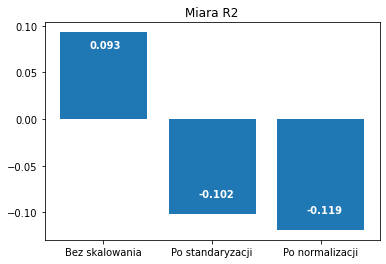

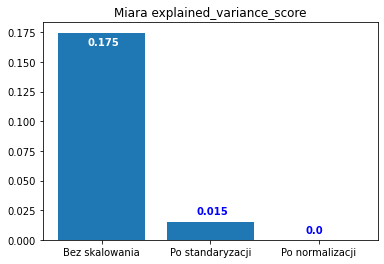

In [35]:
r2 = []
evs = []
rmse = []
for est in fifa_estimators:
    pred = est.best_estimator_.predict(data_test)
    r2.append(r2_score(target_test, pred))
    evs.append(explained_variance_score(target_test, pred))
    rmse.append(math.sqrt(mean_squared_error(target_test, pred)))

_, ax = plt.subplots()
plt.bar(x = ['Bez skalowania', 'Po standaryzacji', 'Po normalizacji'], height = r2)
plt.title('Miara R2')
for i, v in enumerate(r2):
    ax.text(i-0.127, v*0.85 if i==2 else v*0.82, str(round(v, 3)), color='white', fontweight='bold')
plt.show()

_, ax = plt.subplots()
plt.bar(x = ['Bez skalowania', 'Po standaryzacji', 'Po normalizacji'], height = evs)
plt.title('Miara explained_variance_score')
for i, v in enumerate(evs):
    ax.text(i-0.125, v*0.94 if i ==0 else v+0.006, str(round(v, 3)), color='white' if i == 0 else 'blue', fontweight='bold')
plt.show()

Przeprowadzone badania nie wykazały, że skalowanie danych może pozytywnie wpłynąć na skuteczność algorytmu `SVR()`, czego mogą być dwie przyczyny:
* standaryzacja w przypadku tych danych nie przyniosła korzystnych efektów
* popełniłem błąd, którego nie jestem w stanie wyłapać.